# IRT Solver - Unidimensional Latent Variable Data Generation
We first assume that each item measures a single sub-scale, and we report population scores on the same sub-scale. Thus, the problem can be solved separately for every sub-scale.

To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature. We then use our solver (simulated annealing and IRF refinement out loop, with MCMC estimation of $\theta$ within each step).

In [430]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [431]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

In [432]:
# Algorithm parameters.
num_bins = 5
initial_sample_per_bin = 20
num_iterations = 2
num_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# Grid strategy.
method = "uniform-fixed" # "quantile" # "uniform" 

In [433]:
X, theta_exact, b, c, v_exact = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
print("v_exact", v_exact)

v_exact [1.66667612]


(1000, 1)


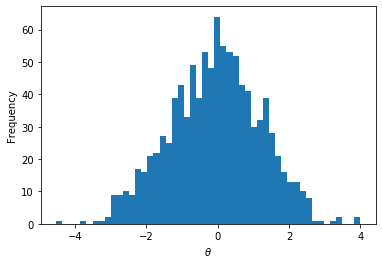

In [434]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta_exact.shape)
plt.hist(theta_exact[:, 0], 50)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

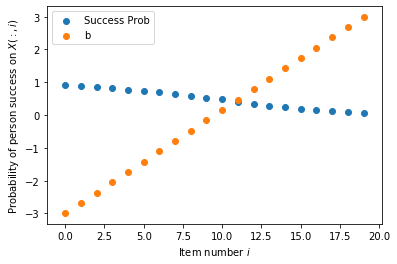

In [435]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend()

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Building IRFs from $\theta$
The IRF of item $i$ is a 1D function of $\theta$ in this case. Use a histogram of the currently "active" persons (those being estimated) to build the IRF.

In [436]:
solver = nirt.solver.Solver(X, c, num_iterations=num_iterations, num_sweeps=num_sweeps, method=method)
theta = nirt.likelihood.initial_guess(X, c)
v = np.var(theta[active], axis=0) ** 2
print(v)

[0.99973071]


In [437]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
inactive = np.arange(P, dtype=int)
active = np.array([], dtype=int)

xlim = [(min(theta[:, ci])-2, max(theta[:, ci])+2) for ci in range(C)]
grid_all = [nirt.grid.Grid(theta[:, ci], num_bins, method=method, xlim=xlim[ci]) for ci in range(C)]
irf_all = [nirt.irf.ItemResponseFunction(grid_all[ci], X[:, i]) for i, ci in enumerate(c)]
print("Grid limits", xlim)

Grid limits [(-4.552430106661507, 4.683973805215119)]


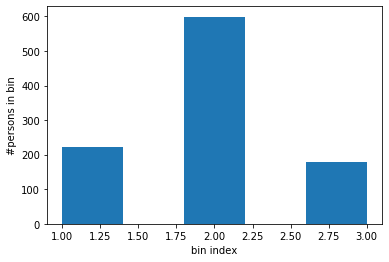

In [438]:
# Print the distribution of bin sizes.
plt.hist(grid_all[0].bin_index, num_bins)
plt.xlabel('bin index')
plt.ylabel('#persons in bin');

In [439]:
# Generate histogram IRFs from a sample of persons.
sample_size = P #initial_sample_per_bin * num_bins
#sample = np.random.choice(inactive, size=sample_size, replace=False)
sample = np.arange(P, dtype=int)
active = np.concatenate((active, sample))
theta_active = theta[sample]

# Index arrays for converting theta[active] into flattened form and back.
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)

In [440]:
grid = [nirt.grid.Grid(theta_active[:, ci], num_bins, method=method, xlim=xlim[ci]) for ci in range(C)]
irf = np.array([nirt.irf.ItemResponseFunction(grid[ci], X[sample, i]) for i, ci in enumerate(c)])
e_all = nirt.error.error_norm_by_item(model_irf, irf_all)
e = nirt.error.error_norm_by_item(model_irf, irf)
print("IRF error of the {} items".format(I))
print("All samples: {:.3f} +- {:.3f}".format(e_all.mean(), e_all.std()))
print("{} samples: {:.3f} +- {:.3f}".format(sample_size, e.mean(), e.std()))

IRF error of the 20 items
All samples: 0.021 +- 0.012
1000 samples: 0.021 +- 0.012


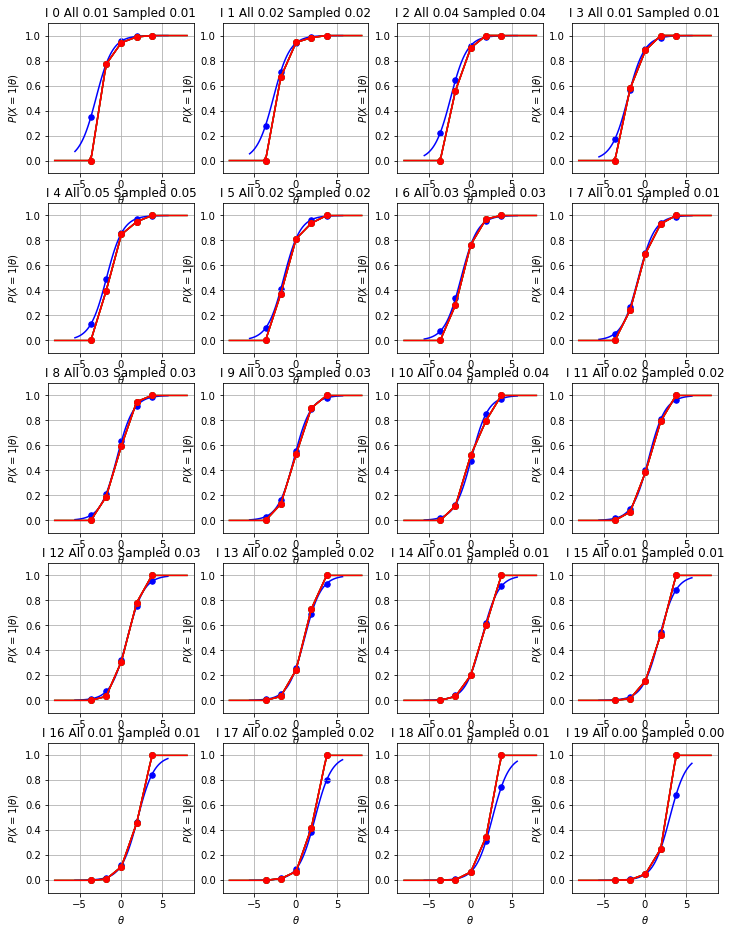

In [441]:
fig, axs = plt.subplots(I // 4, 4, figsize=(12, 0.8*I))
for i in range(I):
    ax = axs[i // 4, i % 4]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], num_bins, color="blue", label="Original")
    irf_all[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
    irf[i].plot(ax, color="red", label="{} samples".format(sample_size))
    ax.set_title("I {} All {:.2f} Sampled {:.2f}".format(i, e_all[i], e[i]))
    ax.grid(True)

$P_i(\theta)$ is generally monotonically increasing. The discrete approximation to the original synthetic (parametric) form is excellent. 20 persons per bin gives a reasonable approximation.

<!-- # Initial Guess for incoming $\theta$ (upon refinement)
When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s. -->

# Improving the initial $\theta$ estimate at the coarsest resolution using MCMC

In [442]:
# temperature = 1e-15
# t = theta[active]
# print(t.shape)

# irf_history = [irf]
# e = nirt.error.error_norm_by_item(model_irf, irf)
# logger.info("t range {:.2f}, {:.2f}".format(t.min(), t.max()))
# logger.info("IRF error: {:.3f} +- {:.3f}".format(e.mean(), e.std()))
# for iter in range(num_iterations):
#     irf = solver._update_irf(num_bins, t)
#     likelihood = nirt.likelihood.Likelihood(X, c, irf)
#     t = solver._improve_theta_by_mcmc(likelihood, t, active_ind, temperature)
#     e = nirt.error.error_norm_by_item(model_irf, irf)
#     logger.info("t range {:.2f}, {:.2f}".format(t.min(), t.max()))
#     logger.info("IRF error: {:.3f} +- {:.3f}".format(e.mean(), e.std()))
#     irf_history.append(irf)
# theta[active] = t

# Initial Guess for incoming $\theta$ (upon refinement)

# Improving $\theta$ at a given temperature with MCMC

In [443]:
# theta = solver.initial_guess()
# n = 10
# T = 1
# t = solver.solve_at_resolution(n, T, theta)

In [444]:
# x = likelihood._irf[dim].x
# print(x)
# L = likelihood.log_likelihood_term(x, v, active=(np.array([p] * x.size), np.array([dim] * x.size)))
# print(L)


# Simpler method: direct MLE for $\theta$

## Exploring MLE (MCMC for T=0) and Likelihood

In the simplest method of iterating between updating IRFs, and improving $\theta$ using the exact MLE, we see divergence ($\theta$ values become unbounded). We explore why below.

In [445]:
# Basic experiment: fix v at its exact value.
v = v_exact
num_iterations = 5

t = theta[active]
irf_history = [irf]
e = nirt.error.error_norm_by_item(model_irf, irf)
logger.info("t range {:.2f}, {:.2f}".format(t.min(), t.max()))
logger.info("IRF error: {:.3f} +- {:.3f}".format(e.mean(), e.std()))
for iter in range(num_iterations):
    logger.info("iter {}/{}".format(iter, num_iterations))
    irf = solver._update_irf(num_bins, t)
    likelihood = nirt.likelihood.Likelihood(X, c, irf)
    t = solver._improve_theta_by_mle(likelihood, t, v, active_ind)
    t = t.reshape(theta_active.shape)
    theta[active] = t
#    v = np.var(theta[active], axis=0) ** 2
    e = nirt.error.error_norm_by_item(model_irf, irf)
    logger.info("t range {:.2f}, {:.2f}".format(t.min(), t.max()))
    logger.info("IRF error: {:.3f} +- {:.3f}".format(e.mean(), e.std()))
    logger.info("v {}".format(v))
    irf_history.append(irf)

INFO     t range -2.55, 2.68
INFO     IRF error: 0.021 +- 0.012
INFO     iter 0/5
INFO     t range -2.62, 2.74
INFO     IRF error: 0.039 +- 0.016
INFO     v [1.66667612]
INFO     iter 1/5
INFO     t range -2.63, 2.73
INFO     IRF error: 0.038 +- 0.017
INFO     v [1.66667612]
INFO     iter 2/5
INFO     t range -2.64, 2.72
INFO     IRF error: 0.037 +- 0.019
INFO     v [1.66667612]
INFO     iter 3/5
INFO     t range -2.64, 2.72
INFO     IRF error: 0.037 +- 0.019
INFO     v [1.66667612]
INFO     iter 4/5
INFO     t range -2.64, 2.72
INFO     IRF error: 0.037 +- 0.019
INFO     v [1.66667612]


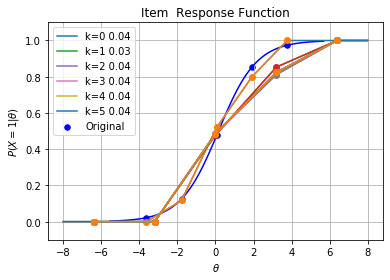

In [446]:
i = 10
ax = plt.gca()
nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], num_bins, color="blue", label="Original")
for k, irf in enumerate(irf_history):
    irf[i].plot(ax, label="k={} {:.2f}".format(k, nirt.error.error_norm(model_irf[i], irf[i])))
ax.grid(True)
ax.legend()

In [447]:
mle = np.array([[likelihood.parameter_mle(p, c, v, max_iter=5) 
                 for c in range(C)] for p in sample])

In [448]:
ind = np.unravel_index(np.argmax(mle, axis=None), mle.shape)
print(ind, sample[ind[0]], mle.max(), mle[ind])

(252, 0) 252 2.724263134412361 2.724263134412361


p 151 c 0 MLE estimator: 2.276686623221657
2.276686623221657 -10.72815530546249


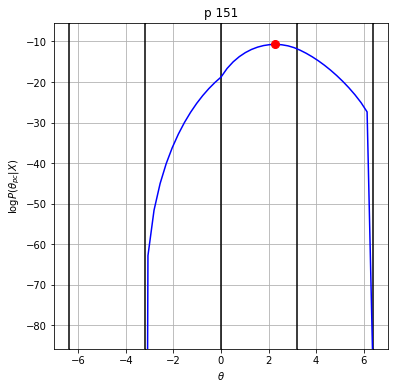

In [449]:
# Check whether the likelihood of a person's theta is concave (has a unique maximum). Verify
# that the MLE is close to the argmax.
dim = 0
v

persons = [151] # sample[:3]
fig, axs = plt.subplots(len(persons), 1, figsize=(6, 6))
for k, p in enumerate(persons):
    ax = axs[k] if len(persons) > 1 else axs
    t_mle = likelihood.parameter_mle(p, dim, v, max_iter=5) 
    print("p {} c {} MLE estimator: {}".format(p, dim, t_mle))
    likelihood.plot_person_log_likelihood(ax, p, dim, v)
    l_mle = likelihood.log_likelihood_term(np.array([t_mle]), v, active=(np.array([p]), np.array([dim])))[0]
    print(t_mle, l_mle)
    ax.plot(t_mle, l_mle, 'ro', markersize=8)
    ax.grid(True)
    ax.set_ylim([8 * l_mle, 0.5 * l_mle])
    ax.set_title("p {}".format(p))
    x = likelihood._irf[dim].x
#    print(x)
    L = likelihood.log_likelihood_term(x, v, active=(np.array([p] * x.size), np.array([dim] * x.size)))
#    print(L)


151
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
2.276686623221657 -10.72815530546249
151 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1] [2.94907004] [2.27668662]
Exact 2.3232323232323235 -9.181794958837656
Approx 2.3232323232323235 -10.730799706769833


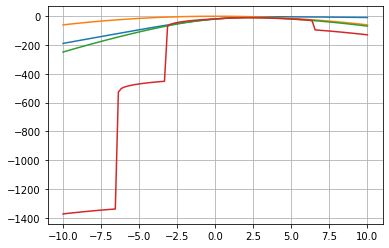

In [450]:
t = np.linspace(-10, 10, 100)
print(p)
x = X[p]

def clipped_log(x):
    return np.log(np.maximum(x, 1e-30))

L = sum(x[i]*clipped_log(model_irf[i](t)) 
              + (1-x[i])*clipped_log(1-model_irf[i](t)) 
                for i in range(I))
L_approx = sum(x[i]*clipped_log(irf[i].interpolant(t)) 
               + (1-x[i])*clipped_log(1-irf[i].interpolant(t)) 
                for i in range(I))
prior = -t**2 / v[0]
L_total = L_exact + prior
L_total_approx = L_approx + prior

likelihood = nirt.likelihood.Likelihood(X, c, irf)
ours = np.array([likelihood._total_likelihood_sum_implementation(ti, p, dim, v)
                 for ti in t])
print(L_total_approx - ours)
t_mle = likelihood.parameter_mle(p, dim, v, max_iter=5)
l_mle = likelihood.log_likelihood_term(np.array([t_mle]), v, active=(np.array([p]), np.array([dim])))[0]
print(t_mle, l_mle)

plt.plot(t, L, label="L_exact")
plt.plot(t, prior, label="prior")
plt.plot(t, L_total, label="L_total_exact")
plt.plot(t, L_total_approx, label="L_total_approx")
plt.grid(True)
#plt.ylim([-10, 0])
#plt.xlim([0, 10])
print(p, X[p], theta_exact[p], theta[p])
print("Exact", t[L_total.argmax()], max(L_total))
print("Approx", t[L_total_approx.argmax()], max(L_total_approx))